In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
import torch

# Test if this speeds up the ECT calculation on hpcc.
from concurrent.futures import ThreadPoolExecutor as ThreadPool
from multiprocessing import cpu_count

# from itertools import starmap

from dataloaders import create_data_loaders, create_datasets
from utils import save_model, save_plots, save_cf, SaveBestModel
from models import CNN

c:\Users\manki\miniconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from ect import ECT, EmbeddedGraph

In [3]:
# Parameters required to define the model. 
# Will remain same throught the excerise.
 
NUM_EPOCHS = 50 # number of epochs to train the network for; type=int
LEARNING_RATE = 1e-3 # learning rate for training; type=float
# loss function
lossfcn = nn.CrossEntropyLoss()

# device
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Functions required for training.
def train(model, train_loader, optimizer, lossfcn, log_level='INFO'):
    model.train()

    log_level = log_level == True or str(log_level).upper() == 'INFO'
    if log_level:
        print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data in train_loader:
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = lossfcn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

# function for validation
def validate(model, valid_loader, lossfcn, log_level='INFO'):
    model.eval()
    if log_level:
        print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        outputs_list = []
        labels_list = []
        for data in valid_loader:
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            outputs_list.append(outputs)
            labels_list.append(labels)
            # calculate the loss
            loss = lossfcn(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))

    return epoch_loss, epoch_acc

In [5]:
# Walk through the full directory structure and find all the numpy files.
def find_numpy_files(directory):
    numpy_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.npy'):
                numpy_files.append(os.path.join(root, file))
    return numpy_files

# Compute the ECT for given numpy file.
def parallel_compute_ect(class_name, file_path, num_dirs, num_thresh, out_file=None, global_bound_radius=2.9092515639765497):
    from ect import ECT, EmbeddedGraph

    G = EmbeddedGraph()
    coords = np.load(file_path)
    G.add_cycle(coords)
    G.set_PCA_coordinates( center_type='min_max', scale_radius=1 )
    
    ect = ECT(num_dirs=num_dirs, num_thresh=num_thresh)
    ect.set_bounding_radius(global_bound_radius)
    ect.calculateECT(G)
    
    if out_file is None:
        return class_name, ect.get_ECT()
    else:
        out_file = os.path.join(out_file, class_name, os.path.basename(file_path))
        np.save(out_file, ect.get_ECT())

# Function to generate the ect dataset.
def generate_ect_dataset(num_dirs,num_thresh, in_path, out_path='example_data/ect_output/', global_bound_radius=2.9092515639765497, in_memory=False, log_level='INFO'):
    '''
    Generate the ECT dataset for the given input data.
    The input data should be in numpy format.
    The ect generation is performed in parallel for each file found in the input directory.
    '''

    log_level = log_level == True or str(log_level).upper() == 'INFO'

    # To avoid re-calculating the ECT for the same parameters.
    # Check previously saved settings.
    setting_path = os.path.join(out_path, '.ect_settings')
    if os.path.exists(setting_path):
        f = open(os.path.join(setting_path), 'r').readlines()
        settings = {}
        for line in f:
            key, value = line.strip().split('=')
            settings[key] = float(value)
        if settings['num_dirs'] == num_dirs and settings['num_thresh'] == num_thresh and settings['global_bound_radius'] == global_bound_radius:
            if log_level:
                print('ECT parameters match the saved settings. Skipping ECT calculation.')
            return

    if type(in_path) == dict:
        # If input is already a dictionary, we assume that the dict values is a list of numpy file path.
        input_numpy_files = in_path 
    else:
        # Use top level directory names as class names.
        classes = [ 
            os.path.basename(d) # Remove the path and get only the directory name.
                for d in os.listdir(in_path) # List all the directories in the input path.
                if os.path.isdir(os.path.join(in_path, d)) # Filter only directories.
        ]
        if log_level:
            print(f'Found {len(classes)} classes in the input directory.')
        
        input_numpy_files = {
            class_name: find_numpy_files(os.path.join(in_path, class_name))
            for class_name in classes
        }
    
    if in_memory:
        out_file_root = None
    else:
        out_file_root = out_path
        for class_name, f_path in input_numpy_files.items():
            os.makedirs(
                os.path.join(out_path, class_name),
                exist_ok=True
            )

    parallel_ect_arguments = [
        (class_name, file_path, num_dirs, num_thresh, out_file_root)
            for class_name, files in input_numpy_files.items()
            for file_path in files
    ]
    
    ects = [ parallel_compute_ect(*i) for i in parallel_ect_arguments ]
    
    # For my laptop this slowed down the calculation rather than speed it up.
    # Perhaps hpcc will benefit from this.
    # with ThreadPool(cpu_count()) as p:
    #     ects = [ i for i in  p.map(
    #         lambda x: parallel_compute_ect(*x), 
    #         parallel_ect_arguments,
    #         chunksize=len(parallel_ect_arguments)//cpu_count()
    #     ) ]
    
    if in_memory:
        data = {a:b for a,b in ects}
    else:
        with open(os.path.join(out_path, '.ect_settings'), 'w') as f:
            f.write(f'num_dirs={num_dirs}\nnum_thresh={num_thresh}\nglobal_bound_radius={global_bound_radius}')

    # Note the syntax of inline if-else statement.
    # value_if_true if condition else value_if_false
    return data if in_memory else None

    # Notice how I have extra code after return statement.
    # This code will never be executed but it's not good practice to have code after return statements.
    # It is useful when testing code if your function takes long time to run.
    # You can put a return statement where you want to test the code.

    # You can also write it as:
    if in_memory:
        return data
    else:
        return None
    
    # Functions always return None if there is no return statement.
    # So you could skip the else part:
    if in_memory:
        return data

In [6]:
def ect_train_validate(
        num_dirs, num_thresh, input_path, output_path="example_data/ect_output", in_memory=False,
        num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
        batch_size=4, valid_split=0.2, num_workers=0,
        log_level='INFO'
):
    data = generate_ect_dataset(
        num_dirs, num_thresh, input_path, in_memory=in_memory, out_path=output_path, log_level=log_level
    )
    data = data if in_memory else output_path
    
    log_level = log_level == True or str(log_level).upper() == 'INFO'

    train_dataset, test_dataset = create_datasets(data, valid_split, log_level)
    train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, batch_size, num_workers)
    trainimages, _ = next(iter(train_loader))
    
    model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1],input_resolution=(num_dirs,num_thresh)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

    save_best_model = SaveBestModel(log_level=log_level)
    train_loss, valid_loss = [],[]
    train_acc, valid_acc = [],[]

    # begin training
    for epoch in range(1,num_epochs+1):
        if log_level:
            print(f"[INFO]: Epoch {epoch} of {num_epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, lossfcn, log_level)
        valid_epoch_loss, valid_epoch_acc = validate(model, test_loader, lossfcn, log_level)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        if log_level:
            print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
            print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

        # save the best model up to current epoch, if we have the least loss in the current epoch
        save_best_model(
            valid_epoch_loss, epoch, model, optimizer, lossfcn
        )
        if log_level:
            print('-'*50)
    output = {
        "num_epochs": num_epochs,
        "model": model,
        "optimizer": optimizer,
        "lossfcn": lossfcn,
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_acc": train_acc,
        "valid_acc": valid_acc,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "train_dataset": train_dataset,
        "test_dataset": test_dataset
    }
    return output

In [7]:
# model, valid_loader, lossfcn
def report_trained_model(
        num_dirs, num_thresh,
        train_dataset, train_loader, test_loader, test_dataset,
        model_path= 'outputs/best_model.pth'
):
    trainimages, trainlabels = next(iter(train_loader))
    model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1],input_resolution=(num_dirs,num_thresh))
    print(model)
    state_dict = torch.load(model_path)['model_state_dict']
    model.load_state_dict(state_dict)
    model.eval()
    model = model.to(device)
    print('Using validation to compute confusion matrix')
    valid_running_pred = []
    valid_running_labels = []
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)

            valid_running_pred.append(preds)
            valid_running_labels.append(labels)
        
    # confusion matrix for the complete epoch
    valid_running_pred = torch.cat(valid_running_pred)
    valid_running_labels = torch.cat(valid_running_labels)
    print('classes:',test_dataset.classes)
    save_cf(valid_running_pred.cpu(),valid_running_labels.cpu(), test_dataset.classes)

In [8]:
# timeit.timeit(
#     '''
# trained_outputs = ect_train_validate(
#         10,10,'example_data/outline_input',log_level='None'
#     )
#     ''',
#     setup='from __main__ import ect_train_validate',
#     number=1
# )
num_dirs = 10
num_thresh = 5

classes = [
    i
        for i in os.listdir('data')
        if os.path.isdir(os.path.join('data', i))
]
class_items = {
    i: find_numpy_files(os.path.join('data', i))
        for i in classes
}

# print( "\n".join( [ f'{i}: {len(j)}' for i,j in class_items.items() ] ) )
# Select random 30 files for each classes, to make it run on my computer.
# You can remove this line to run on all files.
class_items = {
    i: np.random.choice(j, 30, replace=False)
        for i, j in class_items.items()
}
try:
    for i in find_numpy_files('example_data/outputs'):
        os.remove(i)
    os.remove('example_data/outputs/.ect_settings')
    for i in class_items:
        os.removedirs(os.path.join('example_data/outputs', i))
    
except FileNotFoundError:
    pass
print( "\n".join( [ f'{i}: {len(j)}' for i,j in class_items.items() ] ) )

Alstroemeria: 30
Apple: 30
Arabidopsis: 30
Brassica: 30
Coleus: 30
Cotton: 30
Grape: 30
Grass: 30
Ivy: 30
Leafsnap: 30
Passiflora: 30
Pepper: 30
Potato: 30
Tomato_: 30
Transect: 30
Viburnum: 30


In [9]:

trained_outputs = ect_train_validate(
    num_dirs=num_dirs,
    num_thresh=num_thresh,
    input_path=class_items,
    output_path='example_data/outputs',
    log_level='INFO'
)

# ThreadPool => 2 minutes 8.5 seconds vs 1 minute 7.5 seconds without ThreadPool.

['Alstroemeria', 'Apple', 'Arabidopsis', 'Brassica', 'Coleus', 'Cotton', 'Grape', 'Grass', 'Ivy', 'Leafsnap', 'Passiflora', 'Pepper', 'Potato', 'Tomato_', 'Transect', 'Viburnum']
num_classes= 16
ECT data; using only normalize, rotation transforms on training data
[INFO]: Epoch 1 of 50
Training
Validation
Training loss: 9.229, training acc: 4.948
Validation loss: 2.748, validation acc: 7.292

Best validation loss: 2.7479579945405326

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training
Validation
Training loss: 2.776, training acc: 5.469
Validation loss: 2.777, validation acc: 5.208
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training
Validation
Training loss: 2.776, training acc: 5.208
Validation loss: 2.771, validation acc: 4.167
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training
Validation
Training loss: 2.770, training acc: 6.250
Validation loss: 2.790, validation

In [10]:

save_model(
    trained_outputs["num_epochs"],
    trained_outputs["model"],
    trained_outputs["optimizer"],
    trained_outputs["lossfcn"]
)


Saving final model...


(<Figure size 1000x700 with 1 Axes>, <Figure size 1000x700 with 1 Axes>)

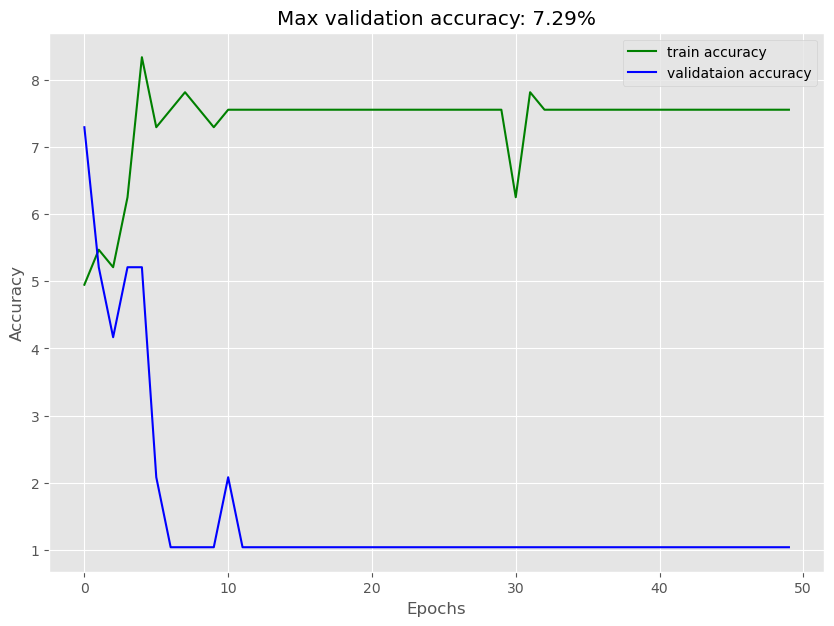

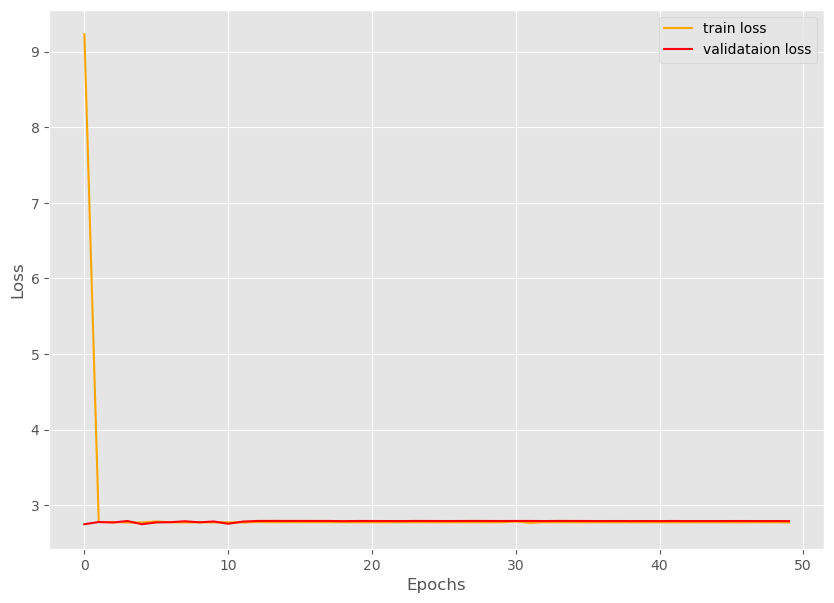

In [11]:

save_plots(
    
    trained_outputs["train_acc"],
    trained_outputs["valid_acc"],
    trained_outputs["train_loss"],
    trained_outputs["valid_loss"],
)


C:\Users\manki\AppData\Local\Temp\ipykernel_19744\202439013.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('outputs/best_model.pth')['model_stat

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=40, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=16, bias=True)
)
Using validation to compute confusion matrix


  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:00<00:00, 515.87it/s]

classes: ['Alstroemeria', 'Apple', 'Arabidopsis', 'Brassica', 'Coleus', 'Cotton', 'Grape', 'Grass', 'Ivy', 'Leafsnap', 'Passiflora', 'Pepper', 'Potato', 'Tomato_', 'Transect', 'Viburnum']



c:\Users\manki\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\manki\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\manki\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

Test Result:
Accuracy Score: 7.29%
_______________________________________________
CLASSIFICATION REPORT:
             0    1    2    3    4    5         6    7    8    9   10   11  \
precision  0.0  0.0  0.0  0.0  0.0  0.0  0.375000  0.0  0.0  0.0  0.0  0.0   
recall     0.0  0.0  0.0  0.0  0.0  0.0  0.500000  0.0  0.0  0.0  0.0  0.0   
f1-score   0.0  0.0  0.0  0.0  0.0  0.0  0.428571  0.0  0.0  0.0  0.0  0.0   
support    5.0  8.0  7.0  1.0  7.0  6.0  6.000000  7.0  6.0  6.0  5.0  7.0   

            12   13        14   15  accuracy  macro avg  weighted avg  
precision  0.0  0.0  0.047059  0.0  0.072917   0.026379      0.025398  
recall     0.0  0.0  1.000000  0.0  0.072917   0.093750      0.072917  
f1-score   0.0  0.0  0.089888  0.0  0.072917   0.032404      0.030531  
support    8.0  7.0  4.000000  6.0  0.072917  96.000000     96.000000  
_______________________________________________
Confusion Matrix: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0]
 [0 0

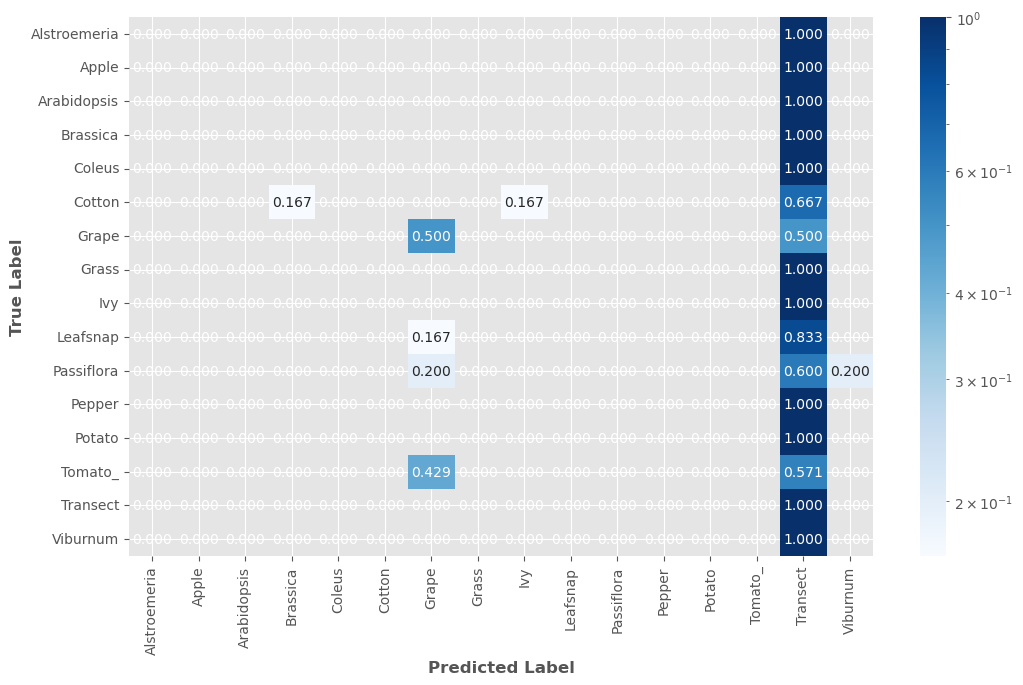

In [12]:

report_trained_model(
    num_dirs, num_thresh,
    trained_outputs["train_dataset"],
    trained_outputs["train_loader"],
    trained_outputs["test_loader"],
    trained_outputs["test_dataset"]
)

In [ ]:
from sklearn.metrics import roc_curve, auc
model = trained_outputs["model"]
model.eval()
model = model.to(device)
print('Using validation to compute ROC curve')
valid_running_pred = []
valid_running_labels = []
counter = 0
with torch.no_grad():
    for i, data in tqdm(enumerate(trained_outputs["test_loader"]), total=len(trained_outputs["test_loader"])):
        counter += 1
        
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(image)
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)

        valid_running_pred.append(outputs)
        valid_running_labels.append(labels)

# confusion matrix for the complete epoch
valid_running_pred = torch.cat(valid_running_pred)
valid_running_labels = torch.cat(valid_running_labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(trained_outputs["test_dataset"].classes)):
    fpr[i], tpr[i], _ = roc_curve(valid_running_labels.cpu().numpy() == i, valid_running_pred.cpu().numpy()[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
for i in range(len(trained_outputs["test_dataset"].classes)):
    plt.plot(fpr[i], tpr[i],
             lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(trained_outputs["test_dataset"].classes[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The following python code will extract the data from the zip files in the data folder and put them in the appropriate folders. The code will create a folder for each class and extract all the class member zip files into that folder. The code will also handle the case where the class member zip files are named with a prefix of the class name.

```python

toplevel = [i for i in os.listdir('data') if not ( i.startswith('.') or i.startswith('2') ) and os.path.isfile(os.path.join('data',i)) ]
classes = {}
for i in toplevel:
    added = False
    i = i[:-4] # Remove the .zip
    for j in toplevel:
        if i == j[:-4]:
            continue
        common = os.path.commonprefix([i,j])
        if len(common) > 5:
            added = True
            classes[common] = classes.get(common,[]) + [j]
    if not added:
        classes[i] = classes.get(i,[]) + [i+'.zip']
[os.makedirs(os.path.join('data',i), exist_ok=True) for i in classes]

import zipfile as zp

for folder, zipfiles in classes.items():
    for z in zipfiles:
        with zp.ZipFile(os.path.join('data',z), 'r') as f:
            names = f.namelist()
            for name in names:
                if name.endswith('.npy'):
                    f.extract(name, os.path.join('data',folder))